In [1]:
import contextlib
from datetime import datetime
from fastai import *
from fastai.tabular import *
import io
import pandas as pd
from pathlib import Path
import random

In [2]:
DATA_PATH = Path('../../data/interim')
path = Path('../../models/')

In [3]:
# Import train_valid_data and test_data dataframes
train_valid_df_raw = pd.read_csv(DATA_PATH/'train_valid_data.csv', low_memory=False)
test_df_raw = pd.read_csv(DATA_PATH/'test_data.csv', low_memory=False)

train_valid_df = train_valid_df_raw.copy()
test_df = test_df_raw.copy()

# Drop week_start as that will get taken into account by add_datepart() for date
train_valid_df.drop('week_start', axis='columns', inplace=True)
test_df.drop('week_start', axis='columns', inplace=True)

# Drop any rows where sales = 0 since we don't need to forecast those
train_valid_df = train_valid_df[train_valid_df.sales != 0]

# Run tabular.add_datepart() on both dfs to add columns about the date: ['Year', 'Month', 'Week', 'Day', 'Dayofweek',
# 'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
tabular.add_datepart(train_valid_df, 'date', drop=True, time=False)
tabular.add_datepart(test_df, 'date', drop=True, time=False)

# Category names, to which we'll apply embeddings
cat_names = ['assortment', 'events', 'promo_interval', 'state', 'state_holiday', 'store_type']

# Add the date-related categories
cat_names += ['Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end',
              'Is_year_start', 'Month', 'Week', 'Year',]

# Continuous-variable names, which we'll make sure are all represented as floats
# Just use set difference to make sure everything is covered
cont_names = list(set(train_valid_df.columns) - set(cat_names))

# Set up transforms to 1) replace missing values for continuous variables by the median column value, 2) transform all
# categorical variables into categories, 3) normalize continuous variables.
# Note that FillMissing should do nothing since we shouldn't have any NaNs -- leaving it in anyway
procs = [FillMissing, Categorify, Normalize]

df = train_valid_df

# Feed zeros for sales to the model to be sure we're not cheating
test_df['sales'] = 0.0

# Validation set is 
valid_idx = range(int(0.8 * len(df)), len(df))
dep_var = 'sales'
print(valid_idx)
print(len(df))

data = (TabularList.from_df(df, path=DATA_PATH, cat_names=cat_names, cont_names=cont_names, procs=procs)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                   .add_test(test_df)
                   .databunch())

data.show_batch()

range(643244, 804056)
804056


assortment,events,promo_interval,state,state_holiday,store_type,Day,Dayofweek,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Month,Week,Year,competition_distance,dew_point_c,sales,mean_wind_speed_km_h,competition_open_since_month,min_humidity,day_of_week,promo,open,max_humidity,min_sea_level_pressureh_pa,competition_open_since_year,Dayofyear,store,max_wind_speed_km_h,promo2,promo2_since_year,cloud_cover,max_sea_level_pressureh_pa,promo2_since_week,customers,mean_sea_level_pressureh_pa,max_visibility_km,school_holiday,min_temperature_c,min_dew_point_c,mean_dew_point_c,mean_visibility_km,max_gust_speed_km_h,mean_temperature_c,wind_dir_degrees,precipitationmm,min_visibility_km,mean_humidity,Elapsed,trend,max_temperature_c,target
a,Rain,None,NW,0,a,23,5,False,False,False,False,False,False,11,47,2013,-0.5958,-0.6387,0.1035,0.2536,-1.9911,1.3191,1.4372,-0.8994,0.0000,-0.0788,0.3052,-0.1657,1.5916,1.1546,-0.4957,-0.9677,0.0256,1.0155,0.3015,-0.0432,0.4651,0.3213,-0.0258,-0.4785,-0.5540,-0.3293,-0.4259,-0.3938,0.0084,-0.7857,-1.9042,-0.3089,-0.2427,0.7809,-0.4113,0.2845,-0.9319,8.909911
c,No Events,None,SH,0,c,15,1,False,False,False,False,False,False,7,29,2014,-0.4141,1.3361,-0.2043,-0.4113,-2.3733,-0.6639,-0.8818,1.1118,0.0000,0.1828,0.1935,0.6334,0.3363,1.4268,-0.8316,-0.9677,0.0256,-0.8969,0.1780,-0.0432,-0.1439,0.3213,0.8396,2.0899,1.1744,1.5175,1.4305,0.7059,0.0084,1.3221,0.6539,-0.3089,-0.2427,-0.8380,0.4988,1.9059,1.2324,8.771215
c,Fog,"Jan,Apr,Jul,Oct",BY,0,a,6,4,False,False,False,False,False,False,9,36,2013,-0.6461,1.1716,0.9046,-1.0762,-0.4626,-0.6130,0.8574,-0.8994,0.0000,0.8369,-0.0300,-0.1657,0.8442,1.4361,-1.3914,1.0334,-0.6440,0.0920,-0.4394,1.6748,1.7513,-0.1528,-1.4320,2.0899,0.2317,0.6781,1.0929,-0.3938,0.0084,1.0410,-1.2860,-0.3089,0.6415,0.0100,-0.7147,-1.2414,1.5931,9.200391
a,Rain,None,BE,0,a,28,0,False,False,False,False,False,False,10,44,2013,-0.4515,0.6778,-0.6472,2.2484,0.6838,-0.7147,-1.4616,-0.8994,0.0000,-0.7329,-2.0411,0.0341,1.3425,0.7989,3.8709,-0.9677,0.0256,0.3780,-1.6742,-0.0432,-0.1389,-1.8122,0.8396,-0.4785,1.0173,0.5102,0.5866,0.2660,5.4932,0.9005,0.3342,0.0062,0.6415,-0.6839,-0.5125,0.1892,0.8717,8.530307
a,Fog-Rain,None,BE,0,a,21,3,False,False,False,False,False,False,8,34,2014,-0.4399,0.3487,-0.8677,-1.0762,1.0660,-1.1215,0.2777,1.1118,0.0000,-0.0788,0.3052,0.4336,0.6908,0.0967,-0.2717,-0.9677,0.0256,-0.8969,-0.3159,-0.0432,-0.6619,-0.0343,0.8396,2.0899,0.3888,0.1744,0.2491,0.4859,0.0084,0.4789,0.6433,-0.0975,0.6415,-0.8380,0.6427,1.1429,0.6312,8.384576


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


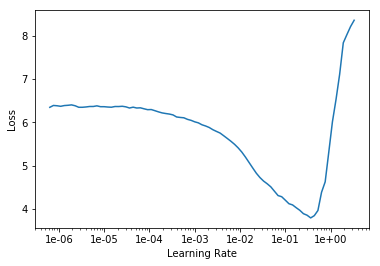

In [6]:
max_log_y = np.log(np.max(df['sales']))
y_range = torch.tensor([0, max_log_y*1.2], device=defaults.device)
learn = tabular_learner(data, layers=[200, 100], ps=[0.0001, 0.001], emb_drop=0.01, metrics=exp_rmspe, y_range=y_range,
                        callback_fns=[partial(callbacks.tracker.TrackerCallback, monitor='exp_rmspe'),
                                      partial(callbacks.tracker.EarlyStoppingCallback, mode='min',
                                              monitor='exp_rmspe', min_delta=0.01, patience=1),
                                      partial(callbacks.tracker.SaveModelCallback, #monitor='exp_rmspe', mode='min',
                                              every='epoch',
                                              name='learn'+datetime.now().strftime("%Y-%m-%d-%X"))])

learn.lr_find()
learn.recorder.plot()

In [7]:
import random
random.seed(42)
learn.fit_one_cycle(cyc_len=10, max_lr=1e-2)

epoch,train_loss,valid_loss,exp_rmspe
1,0.007872,0.002922,0.046776
2,0.006691,0.068292,0.085714


Epoch 3: early stopping


In [8]:
random.seed(41)
learn.fit_one_cycle(cyc_len=10, max_lr=1e-3)

epoch,train_loss,valid_loss,exp_rmspe
1,0.004808,0.006153,0.031422
2,0.005608,0.001178,0.032729


Epoch 3: early stopping


In [9]:
random.seed(41)
learn.fit_one_cycle(cyc_len=10, max_lr=1e-3)

epoch,train_loss,valid_loss,exp_rmspe
1,0.004143,0.000484,0.019317
2,0.004603,0.001055,0.029336


Epoch 3: early stopping


In [10]:
learn.save('latest')

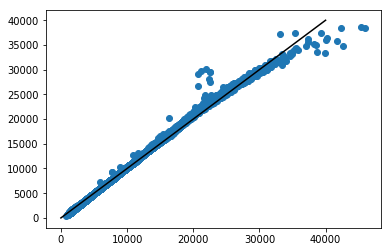

In [21]:
#retrieved = learn.load('latest')
#preds, _ = retrieved.get_preds(ds_type=DatasetType.Valid)
labels = np.exp(preds.numpy())
real = df[643244:len(df)].sales.values
sub = pd.DataFrame({'Predicted': labels[:,0], 'Actual': real})
fig, ax = plt.subplots()
ax.scatter(sub.Predicted, sub.Actual)
#ax.set_xlim([6000,6500])
#ax.set_ylim([6000,6500])
sub.head()
#exp_rmspe(log(sub.Predicted), log(sub.Actual))
log(sub.Predicted).values
ax.plot(np.linspace(0,40000,5000), np.linspace(0,40000,5000), color='black')

In [25]:
retrieved = learn.load('latest')
retrieved.get_preds(ds_type=DatasetType.Test)

AttributeError: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py", line 564, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py", line 94, in __getitem__
    if isinstance(idxs, numbers.Integral): return self.get(idxs)
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/tabular/data.py", line 124, in get
    codes = [] if self.codes is None else self.codes[o]
AttributeError: 'TabularList' object has no attribute 'codes'


In [34]:
#retrieved = learn.load('latest')
test_preds=[]
for i in range(len(test_df[:5])):
    print(i)
    test_preds.append(learn.predict(test_df.iloc[i]))
#test_preds, _ = retrieved.get_preds(ds_type=DatasetType.Test)
test_labels = np.exp(np.array(test_preds))
print('got labels')
test_real = test_df[:5].sales.values
test_sub = pd.DataFrame({'Predicted': labels[:,0], 'Actual': real})
fig, ax = plt.subplots()
ax.scatter(test_sub.Predicted, test_sub.Actual)
log(test_sub.Predicted).values
ax.plot(np.linspace(0,40000,5000), np.linspace(0,40000,5000), color='black')

0
1
2
3
4


AttributeError: 'FloatItem' object has no attribute 'exp'